In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import random
import matplotlib.pyplot as plt
import sys
import os
import shutil
import math
import glob
import traceback
from keras import regularizers

参照するデータを選択

In [2]:
data_name = '1805/180820'

テスト用のデータを作成。

In [3]:
try:    
    class_list = os.listdir(f'D:/whale/data/{data_name}/fig_group')

    for i in range(len(class_list)):
        filelist = []
        valfile = []
        os.makedirs(f'D:/whale/data/{data_name}/target/{i}')
        filelist = sorted(glob.glob(f'D:/whale/data/{data_name}/fig_group/{i}/*.jpg'))
        valfile = random.sample(filelist, int(len(filelist)*0.1))

        for j in valfile:
            shutil.move(j,f'D:/whale/data/{data_name}/target/{i}')
except FileExistsError as e:
    print('テスト用データは既に作成されています。')

ディレクトリ指定。クラス数のメモ。

In [4]:
train_dir = f'D:/whale/data/{data_name}/fig_group'
val_dir = f'D:/whale/data/{data_name}/target'
backup_dir = f'D:/whale/data/{data_name}/model'

labels = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
labels.sort()

num_classes = len(labels)

if os.path.exists(backup_dir):
    shutil.rmtree(backup_dir)

os.makedirs(backup_dir)

with open(backup_dir + '/labels.txt','w') as f:
    for label in labels:
        f.write(label+"\n")

ハイパーパラメータ

In [5]:
# 学習率
learning_rate = 1e-3
# エポック
epochs = 30
# バッチサイズ
batch_size = 128
#画像サイズ
image_size =128

学習開始

In [6]:
#画像のリサイズ
train_data_gen = ImageDataGenerator(rescale=1./255)
val_data_gen = ImageDataGenerator(rescale=1./255)

train_data = train_data_gen.flow_from_directory(
    train_dir, target_size=(image_size, image_size),
    color_mode='rgb', batch_size=batch_size,
    class_mode='categorical', shuffle=True)

validation_data = val_data_gen.flow_from_directory(
    val_dir, target_size=(image_size, image_size),
    color_mode='rgb', batch_size=batch_size,
    class_mode='categorical', shuffle=False)

# AI model definition
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same',
    input_shape=(image_size, image_size, 3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, kernel_regularizer=regularizers.l2(0.001)))
model.add(Activation('relu'))
model.add(Dense(512, kernel_regularizer=regularizers.l2(0.001)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(opt, loss='categorical_crossentropy',
    metrics=['accuracy'])

model.summary()

history = model.fit(train_data, epochs=epochs, validation_data=validation_data, verbose=1)

score = model.evaluate(validation_data)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Found 7735 images belonging to 5 classes.
Found 857 images belonging to 5 classes.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 126, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_______________________________________

グラフの表示

In [7]:

def plot_loss(fit):
    axL.plot(fit.history['loss'],label="loss for training")
    axL.plot(fit.history['val_loss'],label="loss for validation")
    axL.set_title('model loss')
    axL.set_xlabel('epoch')
    axL.set_ylabel('loss')
    axL.legend(loc='best')

def plot_acc(fit):
    axR.plot(fit.history['accuracy'],label="loss for training")
    axR.plot(fit.history['val_accuracy'],label="loss for validation")
    axR.set_title('model accuracy')
    axR.set_xlabel('epoch')
    axR.set_ylabel('accuracy')
    axR.legend(loc='best')

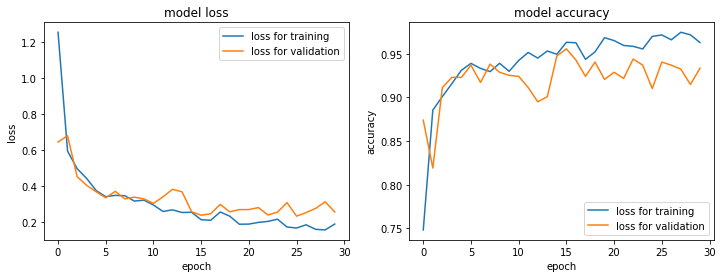

In [8]:
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(12,4))
plot_loss(history)
plot_acc(history)

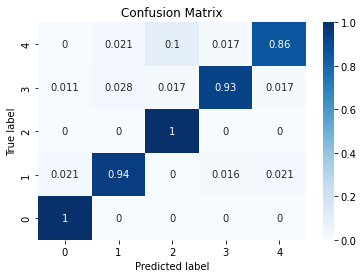

In [9]:
validation_data.reset()
validation_data.shuffle = False
validation_data.batch_size = 1
predicted = model.predict(validation_data, steps=validation_data.n)
predicted_classes = np.argmax(predicted, axis=-1)
cm = confusion_matrix(validation_data.classes,predicted_classes)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True, cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xlim([0.0, len(validation_data.class_indices)])
plt.ylim([0.0, len(validation_data.class_indices)])
plt.show()

In [10]:
# Save model
save_model_path = os.path.join(backup_dir, 'my_model.h5')
model.save(save_model_path)